In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Описание данных
ads_data.csv – данные взаимодействий с рекламными объявлениями

date – дата
time – время
event – действие (просмотр/клик)
platform – платформа
ad_id – id объявления
client_union_id – id рекламного кабинета
campaign_union_id – id рекламной кампании
ad_cost_type – тип оплаты
ad_cost – цена
has_video – есть ли видео
target_audience_count – размер аудитории
ads_clients_data.csv – характеристики рекламных клиентов

date – дата
client_union_id – id рекламного кабинета
community_id – id сообщества
create_date – дата создания рекламного клиента

In [2]:
ads_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-potapejko/shared/homeworks/python_ds_miniprojects/6/ads_data.csv')
ads_clients_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-potapejko/shared/homeworks/python_ds_miniprojects/6/ads_clients_data.csv')

In [3]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [4]:
ads_data.event.fillna(0)

0          view
1          view
2          view
3          view
4          view
          ...  
999995     view
999996     view
999997    click
999998     view
999999     view
Name: event, Length: 1000000, dtype: object

Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. Округлим ответы до целых чисел.

In [5]:
ads_data \
    .groupby(['ad_id', 'event'], as_index=False) \
    .agg({'date': 'count'}) \
    .pivot(index='ad_id', columns='event', values='date') \
    .fillna(0).mean().round()

event
click    113.0
view     923.0
dtype: float64

Посмотрим на распределение показов объявлений

По оси x – число показов
По оси y – доля объявлений с такими показами


In [6]:
ads_views = ads_data \
    .groupby(['ad_id', 'event'], as_index=False) \
    .agg({'date': 'count'}) \
    .query("event == 'view'")

In [7]:
ads_views.date = np.log(ads_views.date)

In [8]:
ads_views.head()

,ad_id,event,date
1,2,view,4.615121
3,3,view,5.214936
5,1902,view,3.713572
6,2064,view,3.555348
8,2132,view,4.060443


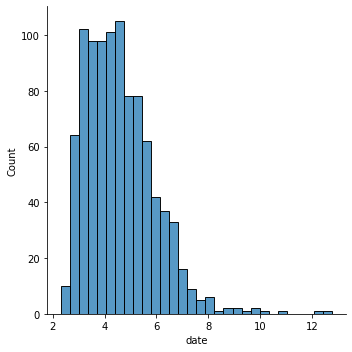

In [9]:
sns.displot(data=ads_views, x='date')
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

Найдем среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитаем скользящее среднее по полученному результату с окном в 2 элемента.

In [10]:
ax_mean = ads_data \
    .query("event == 'view'") \
    .groupby(['date', 'ad_id'], as_index=False) \
    .agg({'has_video': 'count'}) \
    .pivot(index='ad_id', columns='date', values='has_video') \
    .mean()

In [11]:
ax_mean

date
2019-04-01    154.482270
2019-04-02    137.786982
2019-04-03    163.952778
2019-04-04    675.901720
2019-04-05    919.109677
2019-04-06    277.122727
dtype: float64

In [12]:
ax_roll = ax_mean.rolling(2).mean().round()

In [13]:
ax_roll

date
2019-04-01      NaN
2019-04-02    146.0
2019-04-03    151.0
2019-04-04    420.0
2019-04-05    798.0
2019-04-06    598.0
dtype: float64

Нанесем на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных

Посчитаем в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним. Дни, в которых скользящее среднее равно NaN, не учитываем.

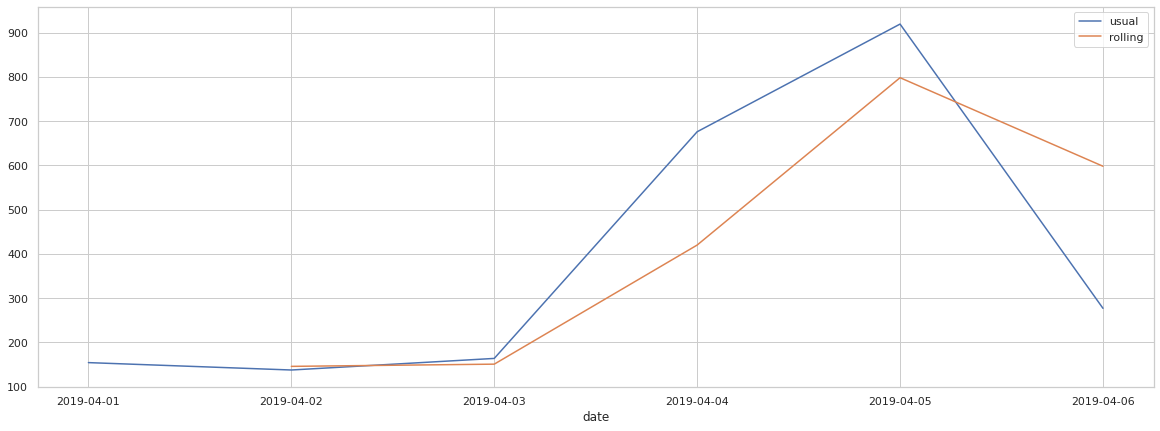

In [225]:
fig, ax = plt.subplots()
sns.lineplot(data=ax_mean, ax=ax, label='usual')
sns.lineplot(data=ax_roll, ax=ax, label='rolling')
ax.tick_params(axis='x')

Объединим данные рекламы с данными о рекламных клиентах и найдем среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

Посчитаем среднее число дней.

In [16]:
ads_full = ads_data.merge(ads_clients_data, on='client_union_id')

In [17]:
ads_full.create_date = pd.to_datetime(ads_full['create_date'])
ads_full.date_x = pd.to_datetime(ads_full['date_x'])

In [18]:
ads_full['diff_date'] = ads_full.date_x - ads_full.create_date

In [20]:
ads_diff = ads_full \
    .groupby('client_union_id') \
    .agg({'diff_date': 'min'})

In [22]:
ads_diff.mean().diff_date

Timedelta('124 days 09:04:43.532219570')

Вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.
Для удобства переведем в проценты и округлим до сотых. 

In [23]:
target_date_delta = pd.Timedelta(365, unit='day')

In [24]:
target_date = ads_diff.diff_date < target_date_delta

In [25]:
(target_date.count() / ads_clients_data.client_union_id.nunique() * 100).round(2)

0.69

In [42]:
target_date.count()

838

In [47]:
ads_clients_data.client_union_id.nunique()

122078

Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

Определим, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). 

In [26]:
ads_full.diff_date.max()

Timedelta('252 days 00:00:00')

In [27]:
ads_bins = ads_full \
    .groupby('client_union_id', as_index=False) \
    .agg({'diff_date': 'min'})

ads_bins['diff_categorical'] = pd.cut(ads_bins.diff_date, bins   = pd.to_timedelta(['0d', '30d', '90d', '180d', '365d']),
                                                          labels = ['0-30', '30-90', '90-180', '180-365'])    

In [28]:
ads_bins.diff_categorical.value_counts()

90-180     396
30-90      263
180-365    168
0-30        11
Name: diff_categorical, dtype: int64

Построим интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них

In [31]:
import plotly.express as px

px.bar(x=ads_bins.diff_categorical, y=ads_bins.client_union_id)